# Load needed libraries

In [1]:
import h5py
import pandas as pd
import numpy as np
import torch
import polars as pl
import gc # Garbage collector
import math
import matplotlib.pyplot as plt

# Load the data

In [2]:
# Load file
file_vbf = h5py.File('../H5Dumper/SimpleVBF.h5', 'r')
file_qcd = h5py.File('../H5Dumper/SimpleQCD.h5', 'r')

# Extract data
df_signal       = pl.DataFrame(file_vbf['INPUTS']['PARTICLES'][:])
df_background   = pl.DataFrame(file_qcd['INPUTS']['PARTICLES'][:])

# Inspect the particle multiplicities

In [3]:
def compare_distributions(signal_data, background_data, variable_name='',n_bins=40):
    plt.figure(figsize=(10, 6),dpi=100)
    if variable_name!='':
        plt.hist(signal_data[variable_name], bins=n_bins,  histtype='step', label='Signal', density=True)
        plt.hist(background_data[variable_name], bins=n_bins, histtype='step', label='Background', density=True)
    else:
        plt.hist(signal_data, bins=n_bins,  histtype='step', label='Signal', density=True)
        plt.hist(background_data, bins=n_bins, histtype='step', label='Background', density=True)
    plt.xlabel(variable_name)
    plt.ylabel('Density')
    plt.title(f'Distribution of {variable_name}')
    plt.legend()
    plt.show()

def obtain_max_n_particles_in_dataset(dataset):

    max_n_particles_per_event = []
    max_n_particles = 0
    for event in range(0,dataset.shape[0]):
        if (event % 100000 == 0):
            print('Reading event %d' % event)
            print('Max number of particles so far = %d' % max_n_particles)
        for particle in range(0,43):
            if math.isnan(dataset[event]['e'][0][particle]):
                if max_n_particles < particle:
                    max_n_particles = particle+1
                max_n_particles_per_event.append(particle+1)
                break

    return max_n_particles, max_n_particles_per_event

In [4]:
max_n_particles_signal, n_particles_signal_dist = obtain_max_n_particles_in_dataset(df_signal)
print('max_particles_signal = ', max_n_particles_signal)

max_n_particles_bg, n_particles_bg_dist = obtain_max_n_particles_in_dataset(df_background)
print('max_particles_background = ', max_n_particles_bg)

Reading event 0
Max number of particles so far = 0
max_particles_signal =  26
Reading event 0
Max number of particles so far = 0
max_particles_background =  20


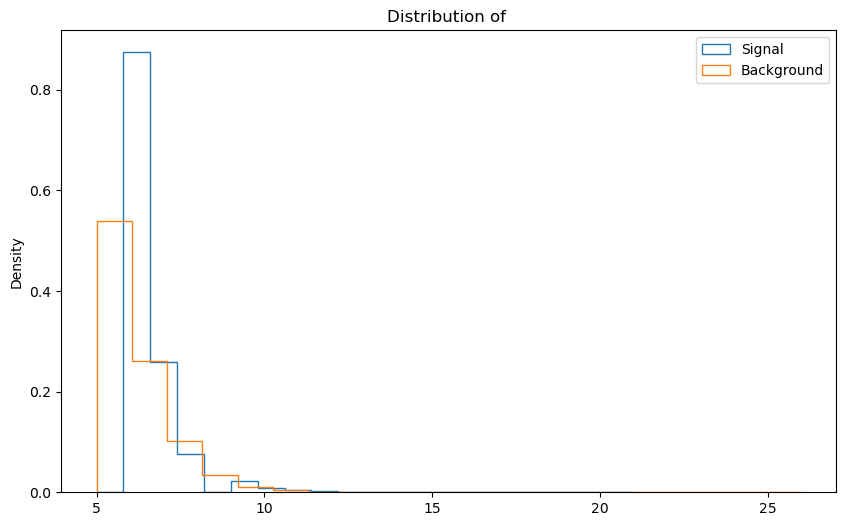

In [6]:
# Plot particle multiplicity
compare_distributions(n_particles_bg_dist,n_particles_signal_dist,n_bins=20)

# Convert dataset to a 2-D table

In [7]:
import multiprocessing

n_particles = 7 # len(df_signal[0]['e'][0]) # Extract from one example

def create_label(label, n_particles):
    return [('%s%d' % (label,i)) for i in range(n_particles)]


df_signal.write_ipc("df_signal.arrow") # This is to be able to load one object in memory and not replicate
df_background.write_ipc("df_background.arrow")

dataset = None

def init_worker(arrow_proxy):
    global dataset
    dataset = pl.read_ipc(arrow_proxy)  # fast zero-copy-ish load


# Worker function to process a single label.
# This function will be executed in a separate process.
def _process_single_label(n_particles, label):
    global dataset
    len_dataset = dataset.height
    print('Converting %s ...' % label) # Mimics original print statement
    
    label_specific_data = {}
    series_for_label = dataset[label] # Get the Polars Series for the current label

    for pID in range(0, n_particles):
        # Initialize column_data with NaNs
        column_data = [np.nan] * len_dataset 
        
        for event_idx in range(0, len_dataset):
            try:
                # Access the list/array of particle data for the current event
                event_data_list = series_for_label[event_idx]
                # Check if the list is not None and pID is within bounds
                if event_data_list is not None and pID < len(event_data_list):
                    column_data[event_idx] = event_data_list[pID]
                else:
                    # Data is missing or pID is out of bounds for this event's list
                    column_data[event_idx] = np.nan 
            except Exception:
                # Fallback for any other errors during data access
                column_data[event_idx] = np.nan 
        
        label_specific_data[label + str(pID)] = column_data

        # Print progress
        if (pID % 5 ==0):
            print('So far done particle %d... ' % pID)

        del column_data
        gc.collect()

    
    del series_for_label
    gc.collect()
    
    return label_specific_data

def create_flat_dataset(arrow_proxy, n_particles, labels=['e','eta','phi','pt','btag','charge','type']):
    global dataset
    new_data = {}

    # Prepare arguments for each task. Each task processes one label.
    tasks = []
    for label in labels:
        tasks.append((n_particles, label))

    # Use a Pool of worker processes.
    # The number of processes defaults to the number of CPU cores.
    with multiprocessing.Pool(initializer=init_worker, initargs=(arrow_proxy,)) as pool:
        # pool.starmap applies _process_single_label to each argument tuple in tasks.
        # It blocks until all results are ready.
        # results_list will be a list of dictionaries, each returned by _process_single_label.
        results_list = pool.starmap(_process_single_label, tasks)

    # Merge the dictionaries from all worker processes
    for single_label_data in results_list:
        new_data.update(single_label_data)

    del results_list
    gc.collect()
            
    return new_data

# Save to csv files

In [8]:
new_df_signal = create_flat_dataset("df_signal.arrow" , n_particles)
signal_df = pl.DataFrame(data = new_df_signal)
del new_df_signal
gc.collect()
signal_df.write_csv('../data/signal_simple_polars.csv')

Converting e ...Converting btag ...Converting eta ...Converting charge ...Converting phi ...Converting type ...Converting pt ...






So far done particle 0... 
So far done particle 0... 
So far done particle 0... So far done particle 0... 

So far done particle 0... 
So far done particle 0... So far done particle 0... 

So far done particle 5... So far done particle 5... So far done particle 5... 


So far done particle 5... 
So far done particle 5... 
So far done particle 5... So far done particle 5... 



In [9]:
# Split into two because of memory limits
new_df_background_p1 = create_flat_dataset("df_background.arrow",n_particles, labels = ['e','eta','phi','pt'])
new_df_background_p2 = create_flat_dataset("df_background.arrow",n_particles, labels = ['btag','charge','type'])
new_df_background_p1.update(new_df_background_p2)

Converting e ...Converting phi ...Converting pt ...Converting eta ...



So far done particle 0... So far done particle 0... 

So far done particle 0... So far done particle 0... 

So far done particle 5... 
So far done particle 5... 
So far done particle 5... 
So far done particle 5... 
Converting btag ...Converting charge ...Converting type ...


So far done particle 0... So far done particle 0... 

So far done particle 0... 
So far done particle 5... So far done particle 5... So far done particle 5... 




In [10]:
background_df = pl.DataFrame(data = new_df_background_p1)
del new_df_background_p1
del new_df_background_p2
gc.collect()
background_df.write_csv('../data/background_simple_polars.csv')

# Plot some of the inputs

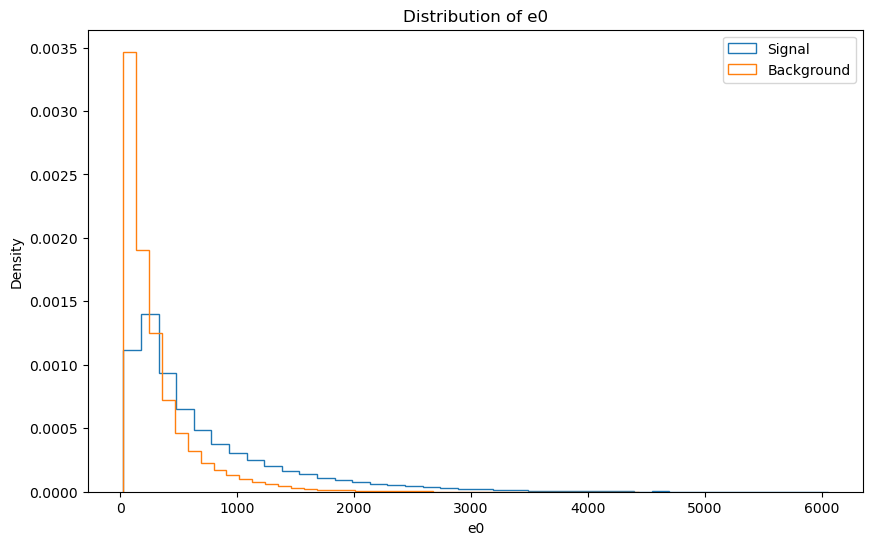

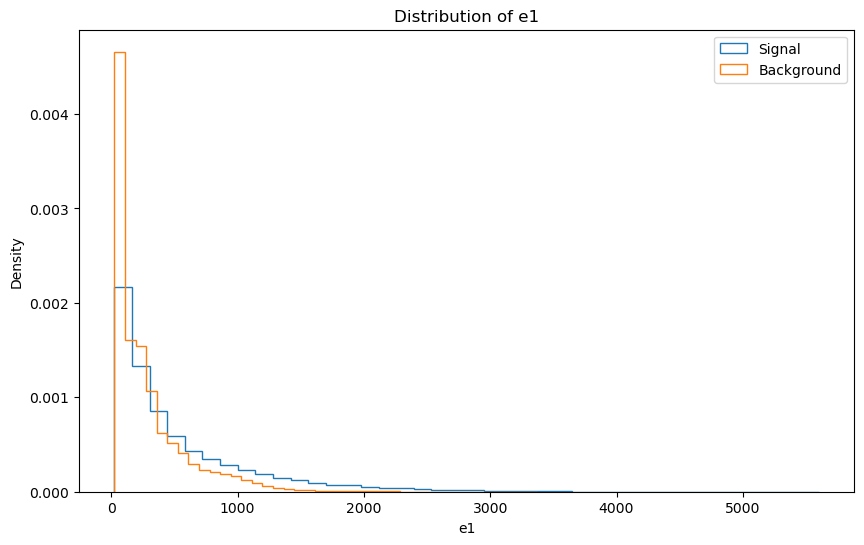

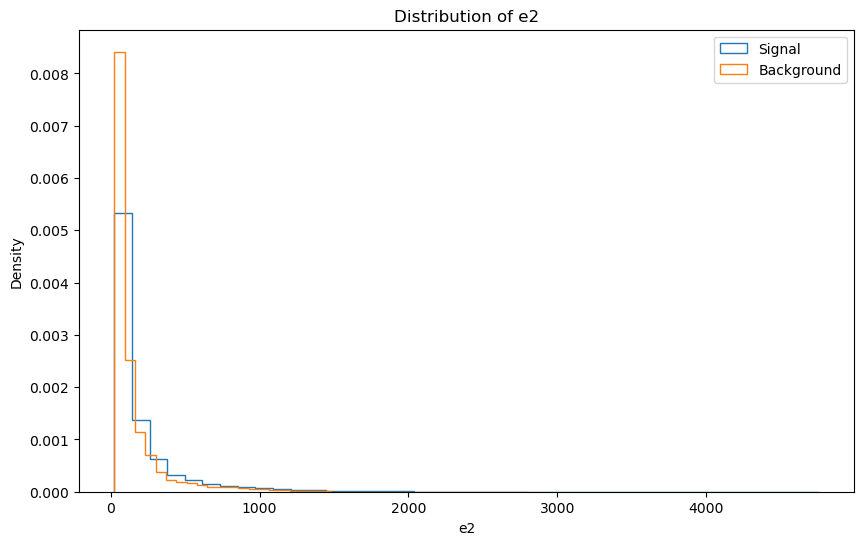

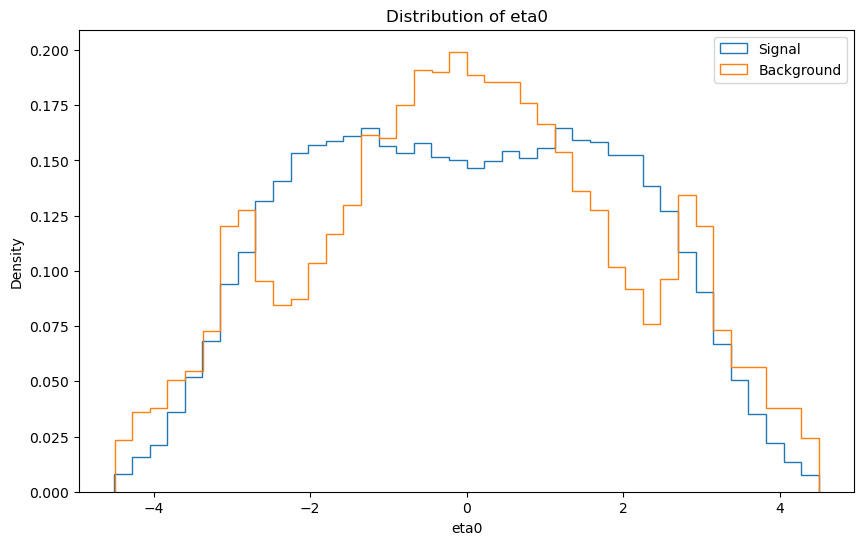

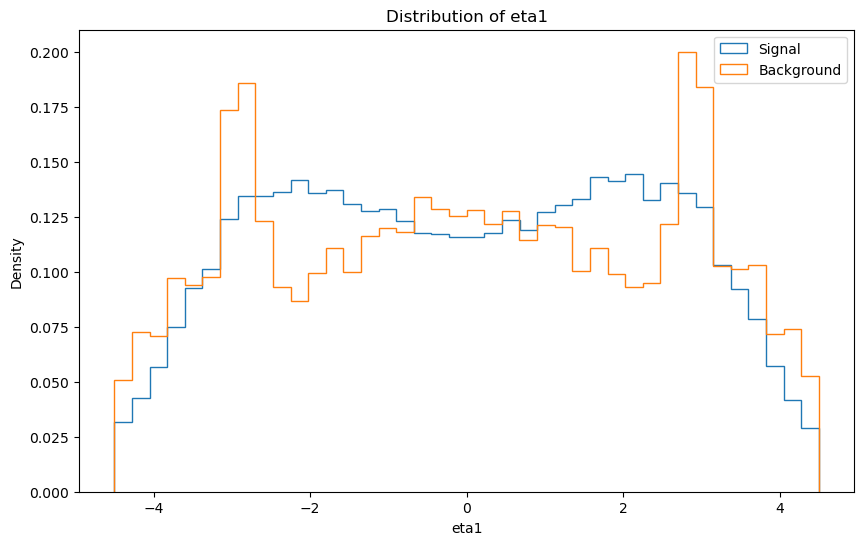

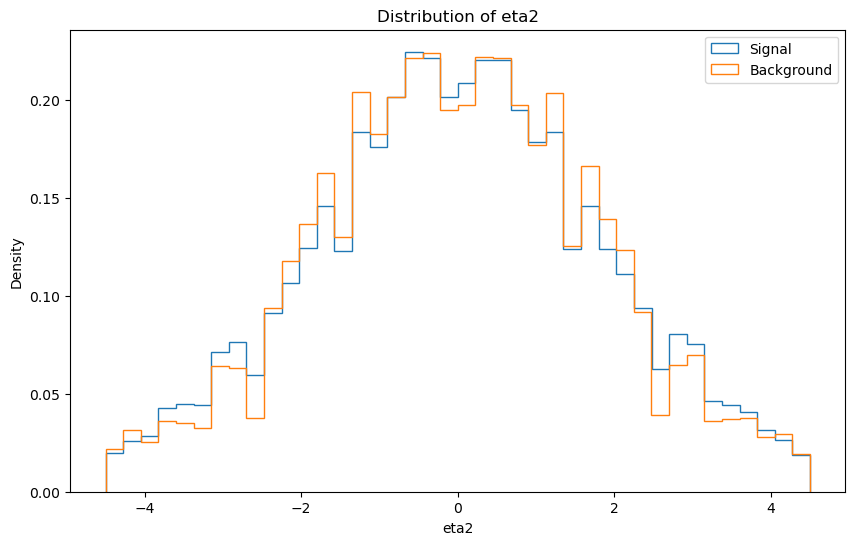

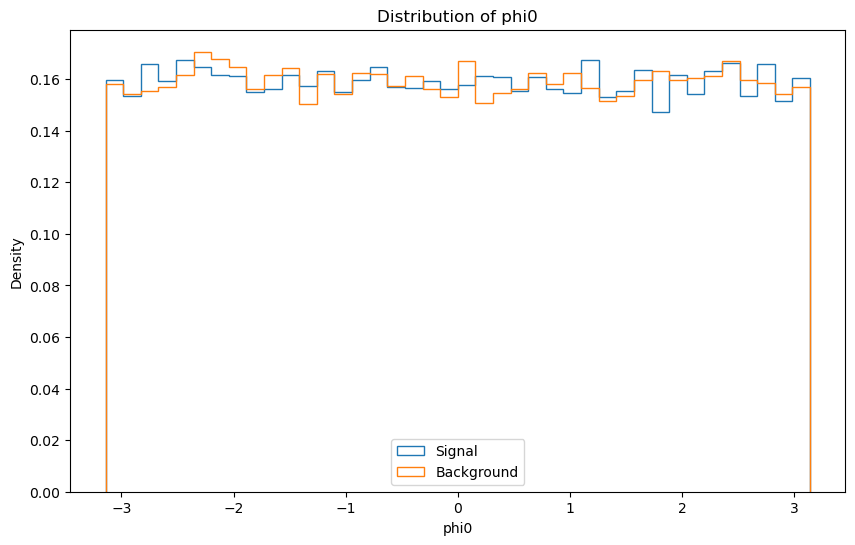

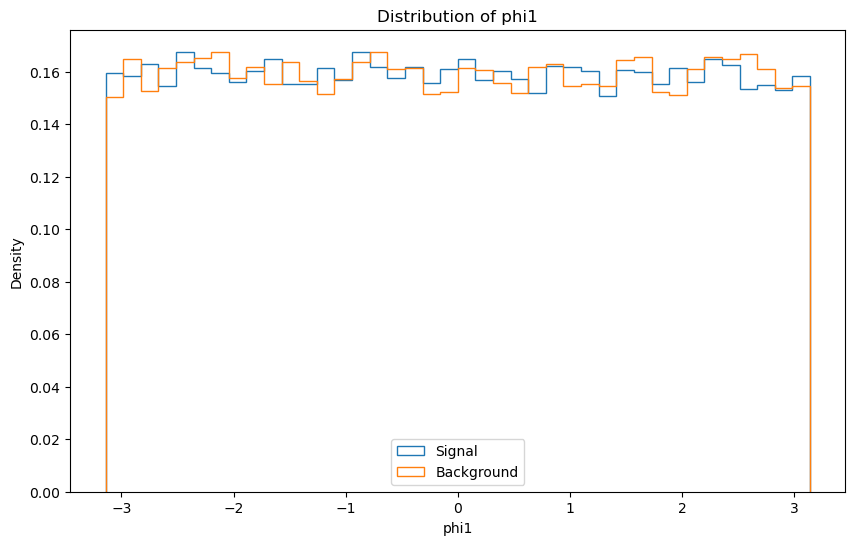

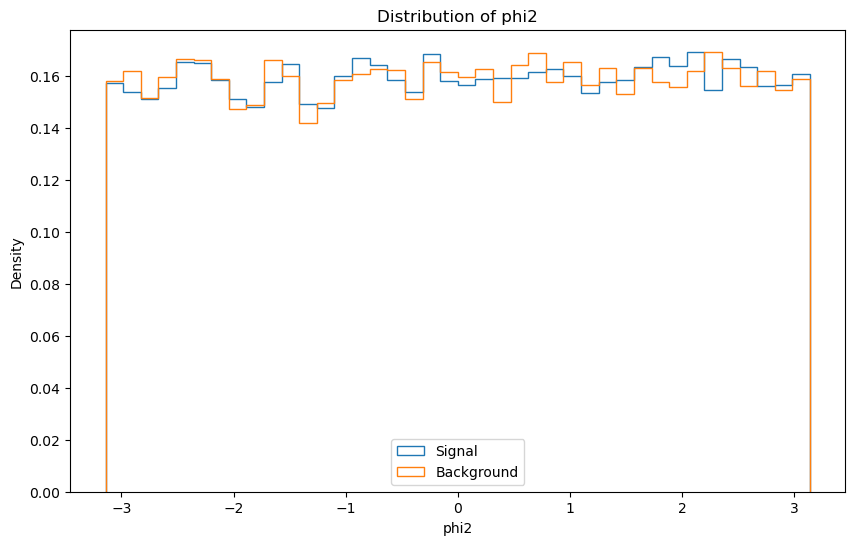

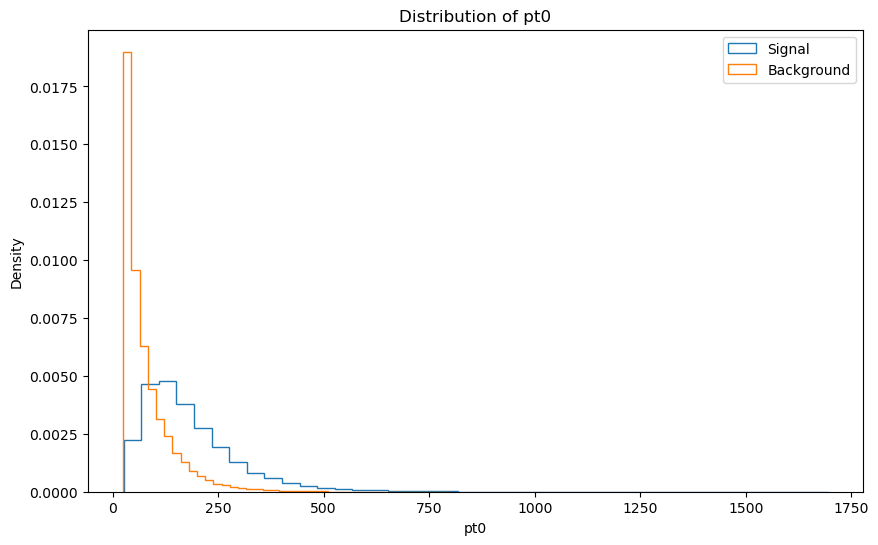

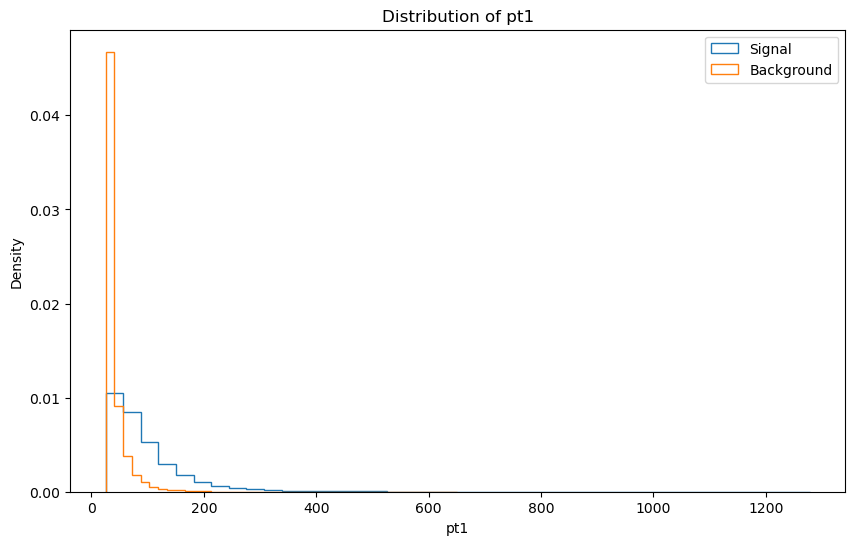

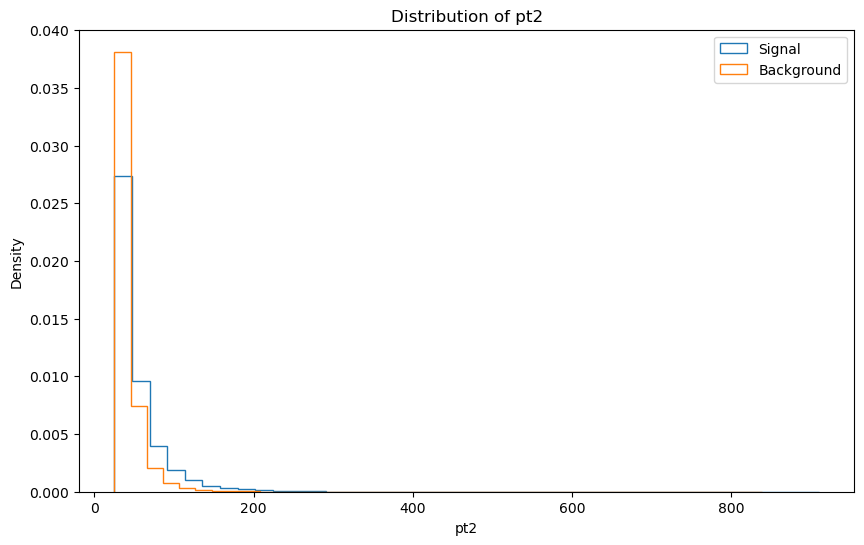

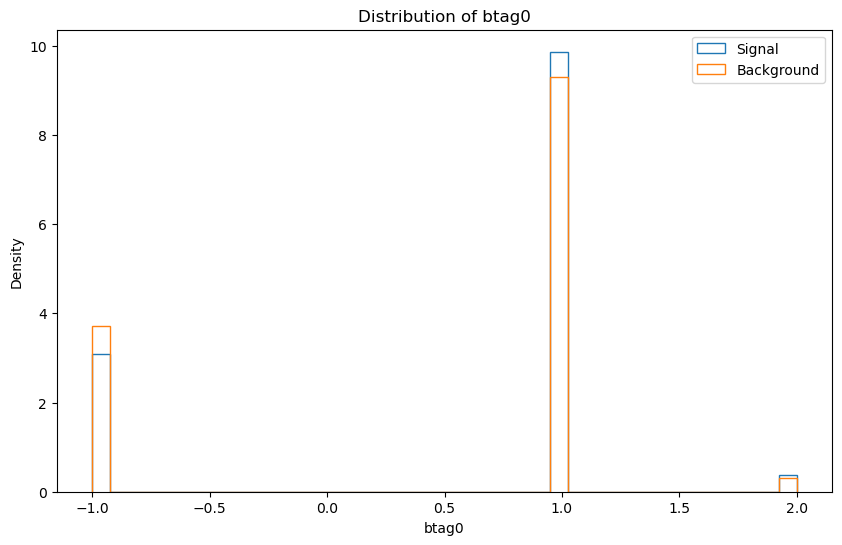

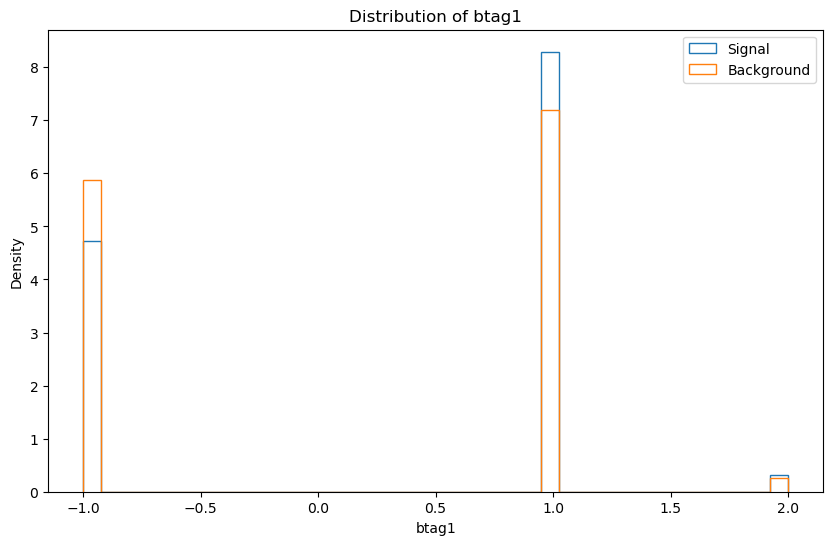

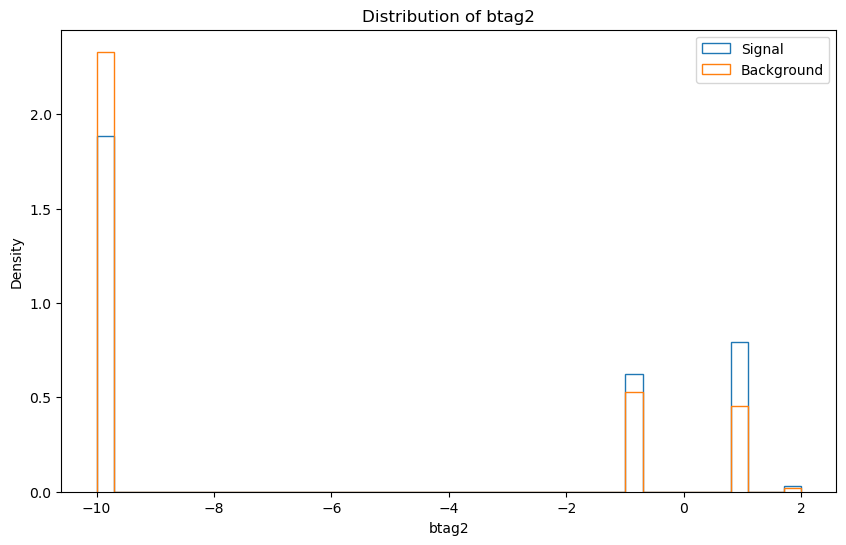

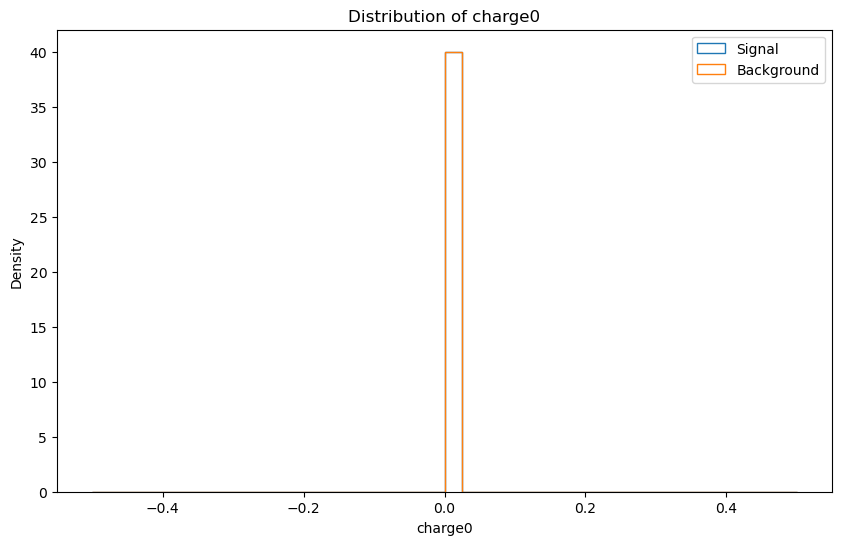

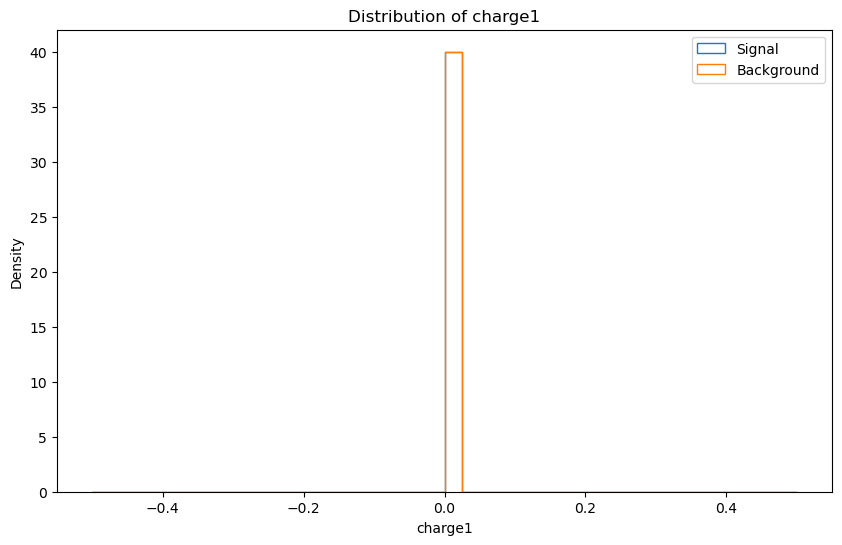

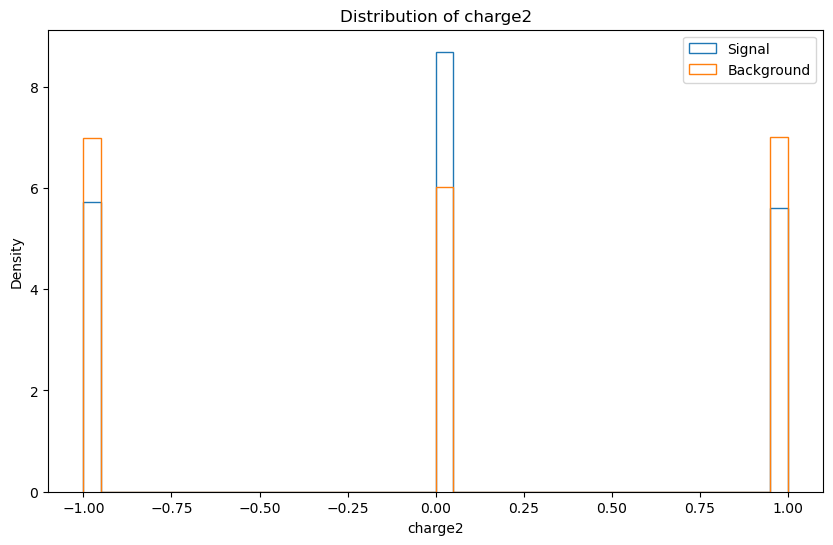

In [11]:
for i in ['e','eta','phi','pt','btag','charge']:
    for j in ['0','1','2']:
        compare_distributions(signal_df[:],background_df[:],i+j)